Some functions are from https://github.com/sicara/easy-few-shot-learning

# Set up

In [ ]:
#@title Imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch import Tensor

from task_sampler import TaskSampler
import random
import pandas as pd
import numpy as np

from typing import List, Tuple

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Set seeds
def set_seeds(seed: int=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds()

In [ ]:
writer = SummaryWriter()

# Data Loading

In [ ]:
features = np.load("<feature vectors>")
labels = np.load('<labels.npy>')

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
def getSplits(indices, i, X, y):
  train_ind = indices[i][0]
  X_train = [X[i] for i in train_ind]
  y_train = [y[i] for i in train_ind]

  test_ind = indices[i][1]
  X_test = [X[i] for i in test_ind]
  y_test = [y[i] for i in test_ind]

  return X_train, y_train, X_test, y_test

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

splits = dict()
for i,ind in enumerate(skf.split(np.zeros(len(encoded_labels)),encoded_labels)):
  splits[i] = ind

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

def create_pipeline(X, y):
    class_distribution = Counter(y)
    print(class_distribution)

    if all(count >= 5 for count in class_distribution.values()):
        sampling_technique = SMOTE(random_state=42, k_neighbors=5, )
        sampling_method = "SMOTE"
    else:
        sampling_technique = SMOTE(random_state=42, k_neighbors=1, )
        sampling_method = "SMOTE"

    pipeline = Pipeline([
        ('sampling', sampling_technique),
    ])

    print(f"Using {sampling_method}")
    return pipeline

In [ ]:
pipeline = create_pipeline(features, encoded_labels)
pipeline.fit(features, encoded_labels)

Counter({3: 68, 9: 59, 5: 51, 1: 30, 12: 28, 10: 21, 8: 17, 4: 14, 7: 12, 11: 11, 6: 10})
Using SMOTE


Pipeline(steps=[('sampling', SMOTE(random_state=42))])

In [ ]:
X, y = pipeline.named_steps['sampling'].fit_resample(features, encoded_labels)

print("Class distribution after resampling:", Counter(y))

Class distribution after resampling: Counter({7: 68, 8: 68, 3: 68, 5: 68, 12: 68, 11: 68, 10: 68, 9: 68, 1: 68, 4: 68, 6: 68})


In [ ]:
maps = dict(zip(range(len(label_encoder.classes_)),label_encoder.classes_))

class DiseaseDataset():
    def __init__(
        self,
        X_train,
        y_train
    ):

        self.data = X_train
        self.labels = y_train
        self.class_names = [maps[i] for i in y_train]

    def __getitem__(self, item: int) -> Tuple[Tensor, int]:

        img = self.data[item]
        label = self.labels[item]

        return torch.Tensor(img), int(label)

    def __len__(self) -> int:
        return len(self.data)

    def get_labels(self) -> List[int]:
        return self.labels

# Model Defintion

In [ ]:
#@title Prototypical Network 

class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=4096, out_features=2048)
        self.layer_2 = nn.Linear(in_features=2048, out_features=1024)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.relu(x)
        return x

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        n_way = len(torch.unique(support_labels))

        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        dists = torch.cdist(z_query, z_proto)
        scores = -dists

        return scores

# Function Definitions

In [ ]:
def evaluate_on_one_task( support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,) -> [int, int]:

    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0

    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


In [ ]:
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()

    classification_scores = model(
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    flat_classification_scores = classification_scores.view(-1, classification_scores.size(-1))
    flat_query_labels = query_labels.view(-1)

    loss = criterion(flat_classification_scores, flat_query_labels.to(device))

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def sliding_average(value_list: List[float], window: int) -> float:
    """
    Computes the average of the latest instances in a list
    Args:
        value_list: input list of floats (can't be empty)
        window: number of instances to take into account. If value is 0 or greater than
            the length of value_list, all instances will be taken into account.

    Returns:
        average of the last window instances in value_list

    Raises:
        ValueError: if the input list is empty
    """
    if len(value_list) == 0:
        raise ValueError("Cannot perform sliding average on an empty list.")
    return np.asarray(value_list[-window:]).mean()

In [ ]:
def train(model,train_loader):

  log_update_frequency = 10

  all_loss = []
  model.train()
  with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
      for episode_index, (
          support_images,
          support_labels,
          query_images,
          query_labels,
          _,
      ) in tqdm_train:


          loss_value = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          if episode_index % log_update_frequency == 0:
              tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

          writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"train_loss": loss_value},
                            global_step=episode_index)

  writer.close()

# Training

In [ ]:
N_WAY = 3  
N_SHOT = 1  
N_QUERY = 2  
N_EVALUATION_TASKS = 100
N_TRAINING_EPISODES = 1500
N_VALIDATION_TASKS = 100

In [ ]:
def calculate_prototypes(X, y):
  prototypes = {}
  for label in np.unique(y):
    indx = np.where(y == label)
    result_list = []

    # Iterate over indices
    for i in indx[0]:
        vec = model.backbone.forward(Tensor(X[i]))
        # print(vec.shape)
        result_list.append(vec.detach().numpy())

    # Compute the mean of all the vectors
    mean_vector = np.mean(result_list, axis=0)
    prototypes[str(label)] = mean_vector.tolist()

  return prototypes

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


def predict_classes(X_test, prototypes):
    y_pred = []
    for sample in X_test:
        min_distance = float('inf')
        predicted_class = None
        vec = model.backbone.forward(Tensor(sample))
        vec = vec.detach().numpy()
        for cls, prototype in prototypes.items():
            distance = euclidean_distance(vec, prototype)
            if distance < min_distance:
                min_distance = distance
                predicted_class = cls
        y_pred.append(int(predicted_class))
    return np.array(y_pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score, silhouette_score,classification_report, f1_score, accuracy_score

def getScores(X_test, y_test):
    y_pred = predict_classes(X_test, calculate_prototypes(X_test, y_test))

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')  # You can choose average='micro', 'macro', 'weighted', or None
    print("F1 Score:", f1)

    precision = precision_score(y_test, y_pred, average='weighted')
    print("Precision:", precision)

    recall = recall_score(y_test, y_pred, average='weighted')
    print("Recall:", recall)

    print(classification_report(y_test, y_pred))

In [ ]:
for fold in range(3):
    X_train, y_train, X_test, y_test = getSplits(splits, fold, X,y)
    train_set = DiseaseDataset(X_train,y_train)

    train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
    )
    train_loader = DataLoader(
        train_set,
        batch_sampler=train_sampler,
        num_workers=2,

        pin_memory=True,
        collate_fn=train_sampler.episodic_collate_fn,
    )

    convolutional_network =  ModelV0()
    convolutional_network.fc = nn.Flatten()
    model = PrototypicalNetworks(convolutional_network).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train(model,train_loader)

    test_set = DiseaseDataset(X_test, y_test)
    test_sampler = TaskSampler(
        test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
    )

    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=2,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
    )

    evaluate(test_loader)

    print(f"Metrics for fold {fold}")
    getScores(X_test, y_test)


# Visualization

In [ ]:
def get_embeddings(X,y):
  prototypes = {}
  for label in np.unique(y):
    indx = np.where(y == label)
    result_list = []

    for i in indx[0]:
        vec = model.backbone.forward(Tensor(X[i]))
        # print(vec.shape)
        result_list.append(vec.detach().numpy())

    # Compute the mean of all the vectors
    mean_vector = np.mean(result_list, axis=0)
    prototypes[label] = dict()
    prototypes[label]["prototype"] = mean_vector
    prototypes[label]["vals"] = result_list

  return prototypes


In [ ]:
train_prototypes, test_prototypes = get_embeddings(X_train,y_train), get_embeddings(X_test,y_test)

In [ ]:
train_values = [vec for i in train_prototypes.values() for vec in i["vals"]]
test_values = [vec for i in test_prototypes.values() for vec in i["vals"]]

train_labels = [k for k, v in train_prototypes.items() for _ in range(len(v["vals"]))]
test_labels = [k for k, v in test_prototypes.items() for _ in range(len(v["vals"]))]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

embeddings2d_train = tsne.fit_transform(np.array(train_values))
embeddingsdf_train = pd.DataFrame()
embeddingsdf_train['labels'] = train_labels
embeddingsdf_train['x'] = embeddings2d_train[:,0]
embeddingsdf_train['y'] = embeddings2d_train[:,1]


embeddings2d_test = tsne.fit_transform(np.array(test_values))
embeddingsdf_test = pd.DataFrame()
embeddingsdf_test['labels'] = test_labels
embeddingsdf_test['x'] = embeddings2d_test[:,0]
embeddingsdf_test['y'] = embeddings2d_test[:,1]



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


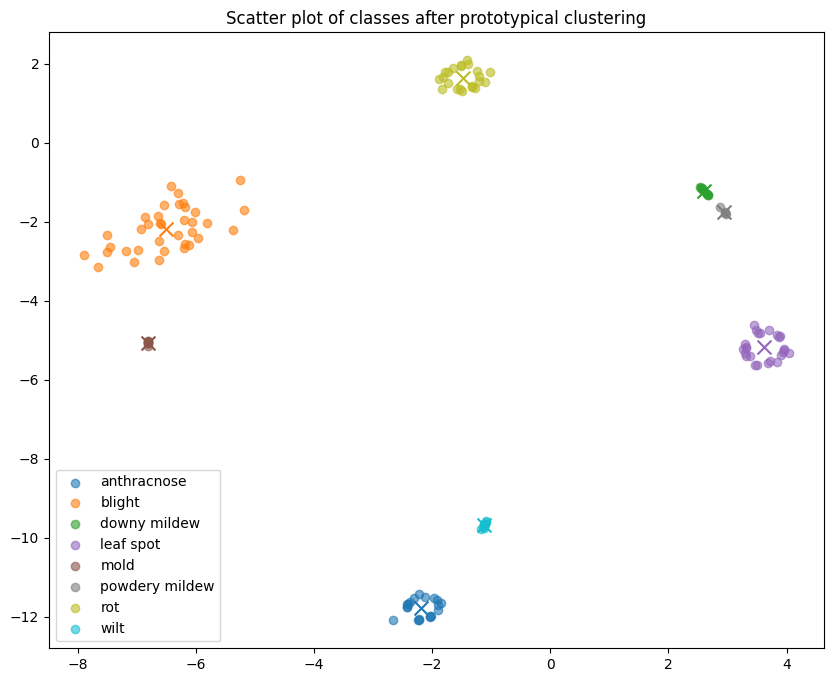

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 8))

cmap = mcolors.ListedColormap([plt.cm.tab10(i/float(len(embeddingsdf_test['labels'].unique())-1)) for i in range(len(embeddingsdf_test['labels'].unique()))])

for i, label in enumerate(embeddingsdf_train['labels'].unique()):
    ax.scatter(embeddingsdf_train[embeddingsdf_train['labels'] == label]['x'],
               embeddingsdf_train[embeddingsdf_train['labels'] == label]['y'],
               color=cmap(i), label=maps[label], alpha=0.6)

    mean_x = embeddingsdf_train[embeddingsdf_train['labels'] == label]['x'].mean()
    mean_y = embeddingsdf_train[embeddingsdf_train['labels'] == label]['y'].mean()

    ax.scatter(mean_x, mean_y, color=cmap(i), marker='x', s=100)

plt.title('Scatter plot of classes after prototypical clustering')
plt.legend()
plt.show()
